# Data Mining Final Project
## Identifying Bird Species from Audio Spectrograms using ML

text

In [13]:
########### Imports ##########

# pip install pandas, etc

import os
from pathlib import Path
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


In [20]:
########### Config & Paths ##########

DATA_ROOT = Path("/Users/lindseywalters/Desktop/ML/Project/birdclef-2023") #main data path
METADATA_PATH = DATA_ROOT / "train_metadata.csv" #metadata CSV file
TRAIN_AUDIO_DIR = DATA_ROOT / "train_audio" #training audio files
SAMPLE_RATE = 32000 #sample rate for all audio, 32 hz
AUDIO_DURATION = 5.0  #5 seconds
NUM_SAMPLES = int(SAMPLE_RATE * AUDIO_DURATION) #compute how many samps correspond to that duration

#spectrogram computations
N_MELS = 64 #number of mel bands (like image height)
N_FFT = 2048 #size of FFT window
HOP_LENGTH = 512 #hop length between frames

#training params
BATCH_SIZE = 32 #number of samps per mini-batch
NUM_EPOCHS = 5 #number of passes over the training data
LEARNING_RATE = 1e-3 #step size for optimizer

DEVICE = torch.device("cpu")

#debugging (delete_)
DEBUG_MODE = False    #false when train on all data
DEBUG_NUM_SAMPLES = 2000

In [40]:
########### Loading metadata and preparing labels ##########

metadata = pd.read_csv(METADATA_PATH)
metadata = metadata.dropna(subset=["primary_label", "filename"])

# Optional debug mode
if DEBUG_MODE:
    metadata = metadata.sample(n=min(DEBUG_NUM_SAMPLES, len(metadata)), random_state=SEED)
    metadata = metadata.reset_index(drop=True)
    print(f"DEBUG MODE ON: Using only {len(metadata)} samples")

# STEP 1: Count species BEFORE assigning integer labels
counts = metadata["primary_label"].value_counts()

# Keep species with at least 2 examples
valid_species = counts[counts >= 2].index

# Filter
metadata = metadata[metadata["primary_label"].isin(valid_species)]
metadata = metadata.reset_index(drop=True)

# STEP 2: Rebuild label mappings AFTER filtering
unique_labels = sorted(metadata["primary_label"].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Assign label indices
metadata["label_idx"] = metadata["primary_label"].map(label_to_index)

print(f"Number of unique species (classes): {len(unique_labels)}")

# STEP 3: Now compute class weights using new label_idx
class_counts = metadata["label_idx"].value_counts().sort_index().values
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights * (len(class_weights) / class_weights.sum())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)


Number of unique species (classes): 257


In [41]:
####### Train/Validation Split ###############

train_df, val_df = train_test_split(
    metadata,
    test_size=0.2, # 80% train, 20% validation
    stratify=metadata["label_idx"],
    random_state=SEED
)

#reset indices to keep things clean
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Train samples: 13547
Validation samples: 3387


In [ ]:
######## Audio Loading and Mel Spectrogram Function ###########

def load_audio(path, sample_rate=SAMPLE_RATE):
    """
    Load an audio file and return a 1D NumPy array and the sample rate.
    """
    #librosa.load loads the audio file, converting it to mono by default
    # sr=sample_rate resamples (or enforces) the given sample rate
    audio, sr = librosa.load(path, sr=sample_rate, mono=True)
    return audio, sr


def random_crop_or_pad(audio, num_samples=NUM_SAMPLES):
    """
    Ensure the audio is exactly `num_samples` long.
    If it's longer, randomly crop a segment.
    If it's shorter, pad with zeros at the end.
    """
    #current length of the audio (in samples)
    current_length = len(audio)

    #if the audio is longer than we need, we randomly choose a start index
    if current_length > num_samples:
        max_start = current_length - num_samples #Max index where a crop of length num_samples can start
        start = np.random.randint(0, max_start + 1) #Randomly select a start index
        audio = audio[start:start + num_samples] #slice out the segment [start : start + num_samples]

    #if the audio is shorter than needed, we pad with zeros
    elif current_length < num_samples:
        pad_amount = num_samples - current_length # Number of zeros to add
        #np.pad adds zeros at the end ('constant' mode with constant_values=0)
        audio = np.pad(audio, (0, pad_amount), mode="constant", constant_values=0.0)

    return audio


def audio_to_mel_spectrogram(audio, sample_rate=SAMPLE_RATE):
    """
    Convert a 1D audio signal into a log-mel spectrogram (2D array).
    """
    #compute mel spectrogram using librosa
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        power=2.0  #use power spectrogram (magnitude squared)
    )

    #convert to log scale (dB). Add a small value to avoid log(0).
    mel_spec_db = librosa.power_to_db(mel_spec + 1e-6, ref=np.max)

    #mel_spec_db has shape [n_mels, time_steps]
    return mel_spec_db


In [42]:
######### Custom Dataset Class #############

class BirdClefDataset(Dataset):
    """
    This dataset:
      - loads audio from disk
      - crops/pads it to a fixed duration
      - converts it to a mel spectrogram
      - returns a tensor and the label index
    """
    def __init__(self, df, audio_dir, sample_rate=SAMPLE_RATE, num_samples=NUM_SAMPLES):
        # Store the DataFrame containing metadata (filenames and labels)
        self.df = df
        # Store the directory containing the .ogg files
        self.audio_dir = audio_dir
        # Store the desired sample rate
        self.sample_rate = sample_rate
        # Store the desired number of samples per clip
        self.num_samples = num_samples

    def __len__(self):
        # Return the total number of samples in this dataset
        return len(self.df)

    def __getitem__(self, idx):
        # Given an index, return the corresponding (input, target) pair

        # Get the row from the DataFrame at that index
        row = self.df.iloc[idx]

        # Extract the filename (e.g., 'XC12345.ogg')
        filename = row["filename"]

        # Build the full path to the audio file
        audio_path = self.audio_dir / filename

        # Load the audio file as a 1D NumPy array
        audio, sr = load_audio(audio_path, sample_rate=self.sample_rate)

        # Crop or pad the audio to a fixed length
        audio = random_crop_or_pad(audio, num_samples=self.num_samples)

        # Convert the audio to a mel spectrogram (2D array: [n_mels, time])
        mel_spec = audio_to_mel_spectrogram(audio, sample_rate=self.sample_rate)

        # Normalize the spectrogram (optional but often helps)
        # We subtract the mean and divide by the standard deviation
        mean = mel_spec.mean()
        std = mel_spec.std() + 1e-9  # add small constant to avoid division by zero
        mel_spec_norm = (mel_spec - mean) / std

        # Convert the spectrogram into a PyTorch tensor
        # Currently shape is [n_mels, time], we add a channel dimension at the front
        # so that shape becomes [channels=1, n_mels, time]
        mel_tensor = torch.tensor(mel_spec_norm, dtype=torch.float32).unsqueeze(0)

        # Extract the label index from the 'label_idx' column
        label_idx = int(row["label_idx"])

        # Convert label index to a PyTorch tensor (for classification)
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        # Return the input tensor and the label tensor
        return mel_tensor, label_tensor


# Create dataset instances for training and validation
train_dataset = BirdClefDataset(train_df, TRAIN_AUDIO_DIR)
val_dataset = BirdClefDataset(val_df, TRAIN_AUDIO_DIR)

# Create DataLoaders to batch and shuffle data
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,       # MUST be 0 on MPS
    pin_memory=False     # MPS does not support pinned memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)


print("DataLoaders ready.")


DataLoaders ready.


In [43]:
# ===============================
# 7. SIMPLE CNN MODEL
# ===============================

class SimpleBirdCNN(nn.Module):
    """
    A simple convolutional neural network for classifying mel spectrograms.
    Input shape: [batch, 1, n_mels, time]
    """
    def __init__(self, num_classes):
        # Call parent constructor
        super(SimpleBirdCNN, self).__init__()

        # First convolutional block:
        # - in_channels=1 (because input spectrogram has 1 channel)
        # - out_channels=16 (we produce 16 feature maps)
        # - kernel_size=3x3 (small receptive field)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # Batch normalization helps stabilize training
        self.bn1 = nn.BatchNorm2d(16)
        # Non-linear activation function
        self.relu1 = nn.ReLU()
        # Max pooling reduces spatial dimensions (height and width)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block, similar to the first but with more channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # At this point, we don't know the exact spatial size (n_mels/time) after 3 pools,
        # so we'll use an adaptive pooling layer to force a fixed output size.
        # This makes the network more robust to variable time dimensions.
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(4, 4))  # produce 4x4 feature maps

        # The number of features after global pooling is 64 channels * 4 * 4 spatial
        self.flatten_dim = 64 * 4 * 4

        # Fully connected (dense) layer to reduce to some hidden size
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # dropout to reduce overfitting

        # Final classification layer: 256 -> num_classes
        self.fc_out = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        Forward pass: defines how input tensor moves through the network.
        """
        # x is shape [batch, 1, n_mels, time]

        # Pass through first conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Global adaptive average pooling to fixed size (4,4)
        x = self.global_pool(x)

        # Flatten the features into a 2D tensor [batch, features]
        x = x.view(x.size(0), -1)

        # Fully connected layer with ReLU and dropout
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)

        # Final output layer (logits for each class)
        x = self.fc_out(x)

        return x


# Create a model instance and move it to the chosen device (CPU or GPU)
num_classes = len(unique_labels)
model = SimpleBirdCNN(num_classes=num_classes).to(DEVICE)

print(model)


SimpleBirdCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.5, inplace=F

In [44]:
# ===============================
# 8. CLASS WEIGHTS, LOSS, OPTIMIZER
# ===============================

# Compute class counts from the training DataFrame
class_counts = train_df["label_idx"].value_counts().sort_index().values  # array of counts per class

# Convert to NumPy float array
class_counts = class_counts.astype(np.float32)

# Compute weights: inverse frequency (more rare = larger weight)
# There are many ways to define weights; this is a simple one.
class_weights = 1.0 / (class_counts + 1e-6)

# Normalize weights so that the average is 1 (optional, but keeps loss magnitude reasonable)
class_weights = class_weights * (len(class_weights) / class_weights.sum())

# Convert to a tensor and move to DEVICE
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

# Define CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Use Adam optimizer on the model parameters
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [45]:
# ===============================
# 9. TRAINING AND VALIDATION LOOPS
# ===============================

def train_one_epoch(model, dataloader, criterion, optimizer, device=DEVICE):
    """
    Train the model for one epoch over the training DataLoader.
    """
    # Set model to training mode (enables dropout, batchnorm updates, etc.)
    model.train()

    # Variables to accumulate total loss and correct predictions
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # Iterate over batches from the DataLoader with a progress bar
    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        # Move inputs and targets to the chosen device (CPU or GPU)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero-out any gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: compute the model outputs (logits)
        outputs = model(inputs)

        # Compute the loss between outputs and true labels
        loss = criterion(outputs, targets)

        # Backward pass: compute gradients
        loss.backward()

        # Take an optimization step to update model parameters
        optimizer.step()

        # Accumulate loss (multiply by batch size to get total)
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size

        # Compute predicted class indices by taking argmax over the class dimension
        _, preds = torch.max(outputs, dim=1)

        # Count how many predictions were correct
        running_correct += (preds == targets).sum().item()

        # Count how many examples we've seen
        running_total += batch_size

    # Compute average loss and accuracy over the entire epoch
    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total

    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device=DEVICE):
    """
    Evaluate the model on the validation DataLoader.
    """
    # Set model to evaluation mode (disables dropout, uses running stats in batchnorm)
    model.eval()

    # Turn off gradient computations for efficiency
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # Disable gradient tracking
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validation", leave=False):
            # Move inputs and targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size

            # Compute predictions
            _, preds = torch.max(outputs, dim=1)

            # Count correct predictions
            running_correct += (preds == targets).sum().item()
            running_total += batch_size

    # Compute average loss and accuracy
    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total

    return epoch_loss, epoch_acc


# ===============================
# 9b. MAIN TRAINING LOOP
# ===============================

# Lists to store loss and accuracy history for plotting later
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")

    # Train on the training set
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device=DEVICE)

    # Evaluate on the validation set
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device=DEVICE)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print epoch summary
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


Epoch 1/5


  Train Loss: 5.5681 | Train Acc: 0.0097
  Val   Loss: 5.5372 | Val   Acc: 0.0171
Epoch 2/5


  Train Loss: 5.5232 | Train Acc: 0.0096
  Val   Loss: 5.5176 | Val   Acc: 0.0159
Epoch 3/5


  Train Loss: 5.5150 | Train Acc: 0.0101
  Val   Loss: 5.5447 | Val   Acc: 0.0103
Epoch 4/5


  Train Loss: 5.5214 | Train Acc: 0.0111
  Val   Loss: 5.4808 | Val   Acc: 0.0130
Epoch 5/5


  Train Loss: 5.4914 | Train Acc: 0.0109
  Val   Loss: 5.5169 | Val   Acc: 0.0115


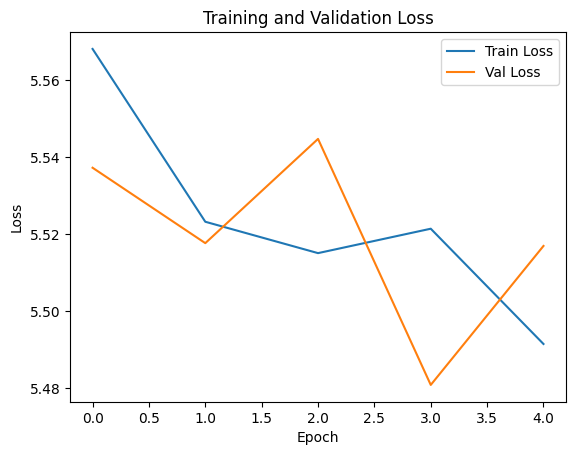

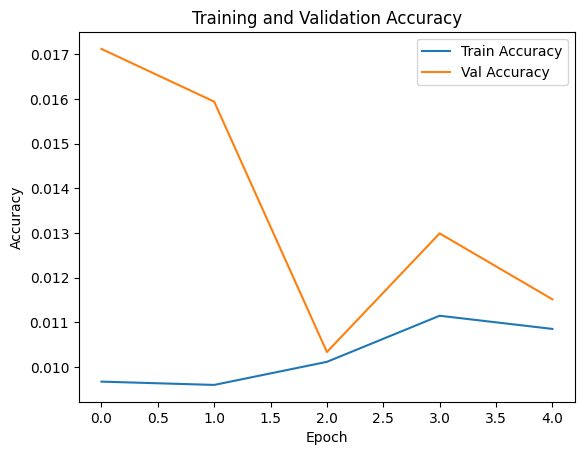

In [ ]:

# PLOT TRAINING AND VALIDATION CURVES
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


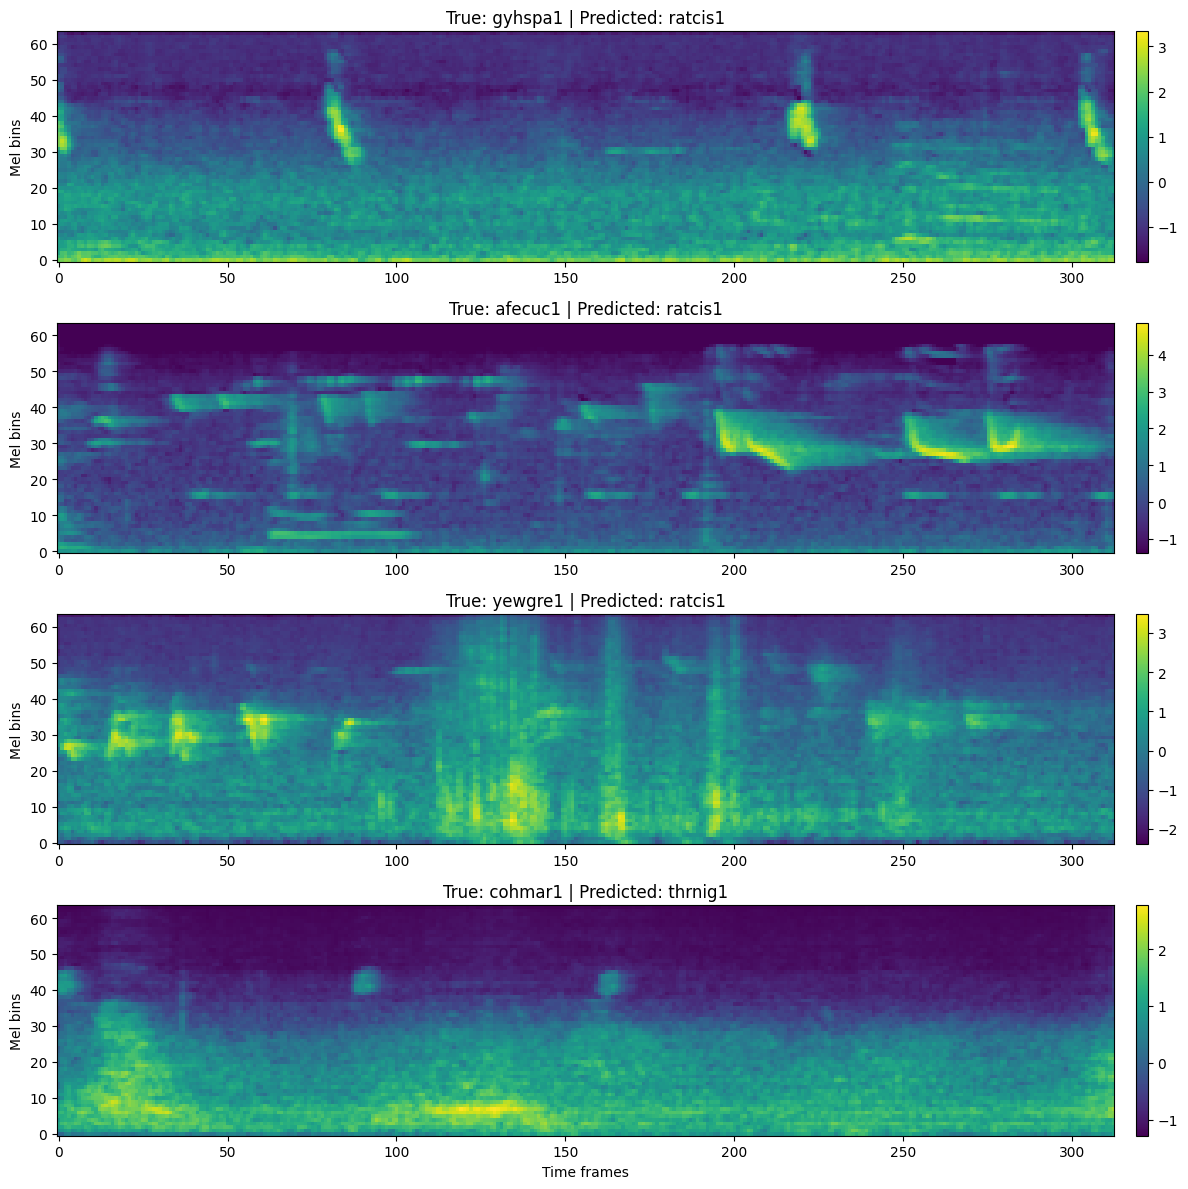

In [ ]:
#cisualize

def show_example_predictions(model, dataset, num_examples=4, device=DEVICE):
    """
    Show a few random examples from the dataset with their predicted and true labels,
    along with the mel spectrograms.
    """
    # Set model to evaluation mode
    model.eval()

    # Randomly select some indices from the dataset
    indices = np.random.choice(len(dataset), size=num_examples, replace=False)

    # Create a subplot grid
    plt.figure(figsize=(12, 3 * num_examples))

    for i, idx in enumerate(indices):
        # Get the input and label from the dataset (on CPU)
        mel_tensor, label_tensor = dataset[idx]

        # Add batch dimension and move to device for prediction
        input_batch = mel_tensor.unsqueeze(0).to(device)  # shape [1, 1, n_mels, time]

        with torch.no_grad():
            # Forward pass
            outputs = model(input_batch)
            # Get predicted class index
            _, pred_idx = torch.max(outputs, dim=1)

        # Convert tensors to Python ints
        true_idx = label_tensor.item()
        pred_idx = pred_idx.item()

        # Decode class indices to labels
        true_label = index_to_label[true_idx]
        pred_label = index_to_label[pred_idx]

        # Convert mel spectrogram back to NumPy for plotting
        mel_np = mel_tensor.squeeze(0).numpy()  # shape [n_mels, time]

        # Plot this spectrogram
        ax = plt.subplot(num_examples, 1, i + 1)
        im = ax.imshow(mel_np, aspect="auto", origin="lower")
        ax.set_title(f"True: {true_label} | Predicted: {pred_label}")
        ax.set_ylabel("Mel bins")
        plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)

    plt.xlabel("Time frames")
    plt.tight_layout()
    plt.show()


# Call the function to display a few examples from the validation dataset
show_example_predictions(model, val_dataset, num_examples=4, device=DEVICE)
